In [51]:
%matplotlib inline
from vic.dataloader import load_orl, load_yale, make_fixed_test_indices
from vic.metrics import (
    get_metrics_vs_train_size,
    get_average_acc_vs_train_size,
    get_metrics_vs_train_size_joblib,
)
from vic.models import Fisherfaces
from vic.transform import transform_test_set
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score


Fisherfaces applies PCA then LDA. We keep a fixed test set per dataset for fair
comparisons across train sizes, and only degrade the test images when studying
robustness.


In [52]:
seed = 0
n_test = 3
n_exp = 10

fisherfaces_kwargs = {
    "strict": False,
    "normalize": False,
    "random_state": 0,
}

def make_fisherfaces():
    return Fisherfaces(**fisherfaces_kwargs)

def make_pool_permutation(data, pool_idx, seed=0):
    rng = np.random.default_rng(seed)
    return {sid: rng.permutation(pool_idx[sid]) for sid in data}

def get_metrics_vs_train_size_nested(model_factory, train_sizes, data, test_idx, pool_perm):
    accuracy_scores = {}
    for train_size in train_sizes:
        Xtr, ytr, Xte, yte = [], [], [], []
        for sid, imgs in data.items():
            tr = pool_perm[sid][:train_size]
            te = test_idx[sid]
            Xtr.append(imgs[tr])
            ytr.append(np.full(len(tr), sid))
            Xte.append(imgs[te])
            yte.append(np.full(len(te), sid))
        Xtr = np.concatenate(Xtr)
        ytr = np.concatenate(ytr)
        Xte = np.concatenate(Xte)
        yte = np.concatenate(yte)
        model = model_factory()
        model.fit(Xtr, ytr)
        y_pred = model.predict(Xte)
        accuracy_scores[train_size] = accuracy_score(yte, y_pred)
    return accuracy_scores


# ORL Dataset Experiments (Fisherfaces)


In [53]:
data = load_orl("../data/ORL")
max_idx = max(data.keys())
min_length = min(len(images) for images in data.values())
print(
    f"Loaded ORL dataset with {max_idx} subjects with at least {min_length} images each."
)

train_sizes = np.arange(2, min_length - n_test + 1)
test_idx, pool_idx = make_fixed_test_indices(data, n_test=n_test, seed=seed)


Loaded ORL dataset with 40 subjects with at least 10 images each.


In [54]:
model = Fisherfaces(**fisherfaces_kwargs)
print(f"Evaluating Fisherfaces on ORL dataset with train sizes: {train_sizes}")
accuracy_scores, conf_matrices = get_metrics_vs_train_size(
    model, train_sizes, data, test_idx, pool_idx, seed=seed
)


Evaluating Fisherfaces on ORL dataset with train sizes: [2 3 4 5 6 7]


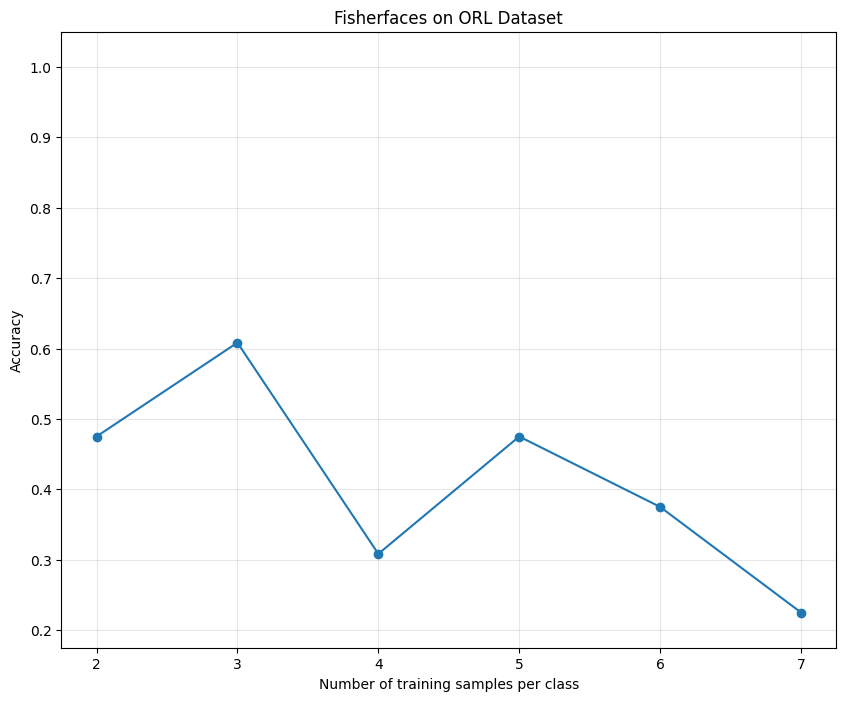

In [55]:
fig = plt.figure(figsize=(10, 8))
plt.plot(train_sizes, accuracy_scores.values(), marker="o")
plt.title("Fisherfaces on ORL Dataset")
plt.xlabel("Number of training samples per class")
plt.ylabel("Accuracy")
plt.xticks(train_sizes)
plt.grid(True, alpha=0.3)
plt.ylim(min(accuracy_scores.values()) - 0.05, 1.05)
plt.show()


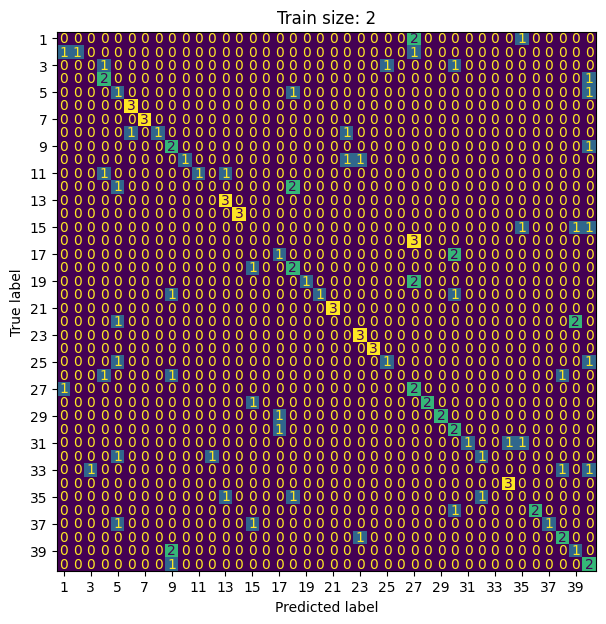

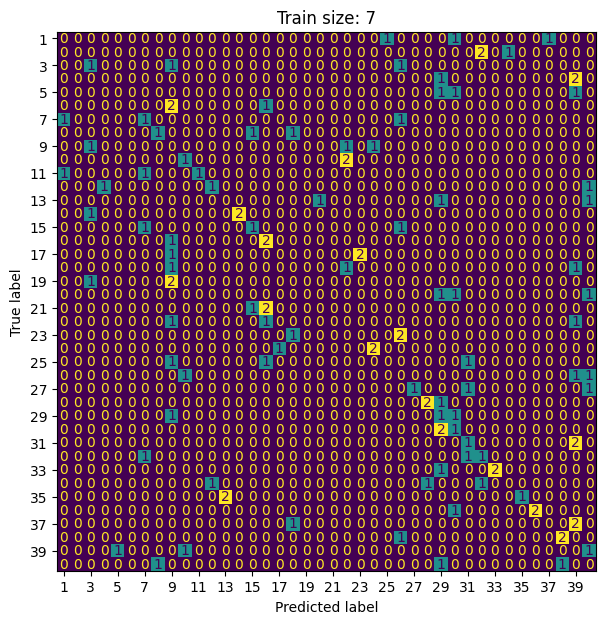

In [56]:
sizes_to_plot = [train_sizes[0], train_sizes[-1]]

for size in sizes_to_plot:
    cm = conf_matrices[size]

    fig, ax = plt.subplots(figsize=(7, 7))

    labels = np.arange(1, cm.shape[0] + 1)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(colorbar=False, ax=ax)

    tick_positions = np.arange(0, cm.shape[0], 2)
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(labels[tick_positions])
    ax.set_yticks(tick_positions)
    ax.set_yticklabels(labels[tick_positions])

    plt.title(f"Train size: {size}")
    plt.show()


Experiments: 100%|██████████| 10/10 [00:16<00:00,  1.69s/it]


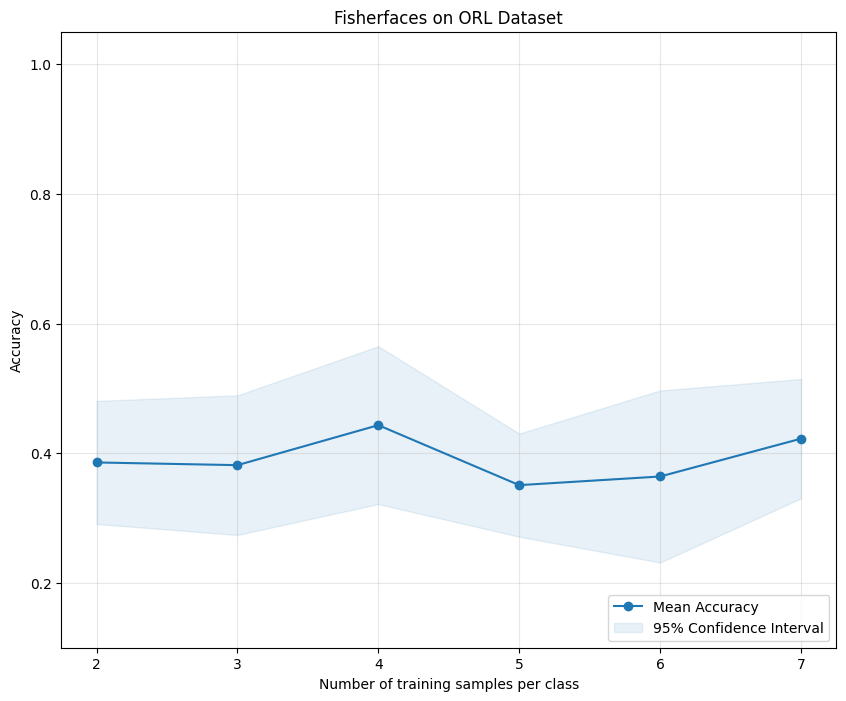

In [57]:
mean_scores, std_scores = get_average_acc_vs_train_size(
    model, train_sizes, data, test_idx, pool_idx, n_exp=n_exp, seed_master=seed
)

sorted_sizes = sorted(mean_scores.keys())
means = np.array([mean_scores[k] for k in sorted_sizes])
stds = np.array([std_scores[k] for k in sorted_sizes])
ci = 1.96 * stds / np.sqrt(n_exp)

fig = plt.figure(figsize=(10, 8))

plt.plot(sorted_sizes, means, marker="o", color="tab:blue", label="Mean Accuracy")

plt.fill_between(
    sorted_sizes,
    means - ci,
    means + ci,
    alpha=0.1,
    color="tab:blue",
    label="95% Confidence Interval",
)

plt.title("Fisherfaces on ORL Dataset")
plt.xlabel("Number of training samples per class")
plt.ylabel("Accuracy")

plt.xticks(sorted_sizes)

plt.grid(True, alpha=0.3)
plt.legend(loc="lower right")

y_min = max(0, min(means - stds) - 0.05)
plt.ylim(y_min, 1.05)

plt.show()


# ORL Variant Comparison (Averaged)


In [58]:
n_classes = len(data)
n_features = data[next(iter(data))][0].size
min_train_size = int(train_sizes[0])
k_pca_fixed = min(n_classes * (min_train_size - 1), n_features)
k_lda_fixed = min(n_classes - 1, k_pca_fixed)

fixed_pca_kwargs = {
    **fisherfaces_kwargs,
    "n_components_pca": k_pca_fixed,
    "n_components_lda": k_lda_fixed,
}
normalized_kwargs = {**fisherfaces_kwargs, "normalize": True}
strict_kwargs = {**fisherfaces_kwargs, "strict": True}

model_fixed = Fisherfaces(**fixed_pca_kwargs)
model_norm = Fisherfaces(**normalized_kwargs)
model_strict = Fisherfaces(**strict_kwargs)

mean_scores_fixed, _ = get_average_acc_vs_train_size(
    model_fixed, train_sizes, data, test_idx, pool_idx, n_exp=n_exp, seed_master=seed
)
mean_scores_norm, _ = get_average_acc_vs_train_size(
    model_norm, train_sizes, data, test_idx, pool_idx, n_exp=n_exp, seed_master=seed
)
mean_scores_strict, _ = get_average_acc_vs_train_size(
    model_strict, train_sizes, data, test_idx, pool_idx, n_exp=n_exp, seed_master=seed
)


Experiments: 100%|██████████| 10/10 [00:25<00:00,  2.54s/it]


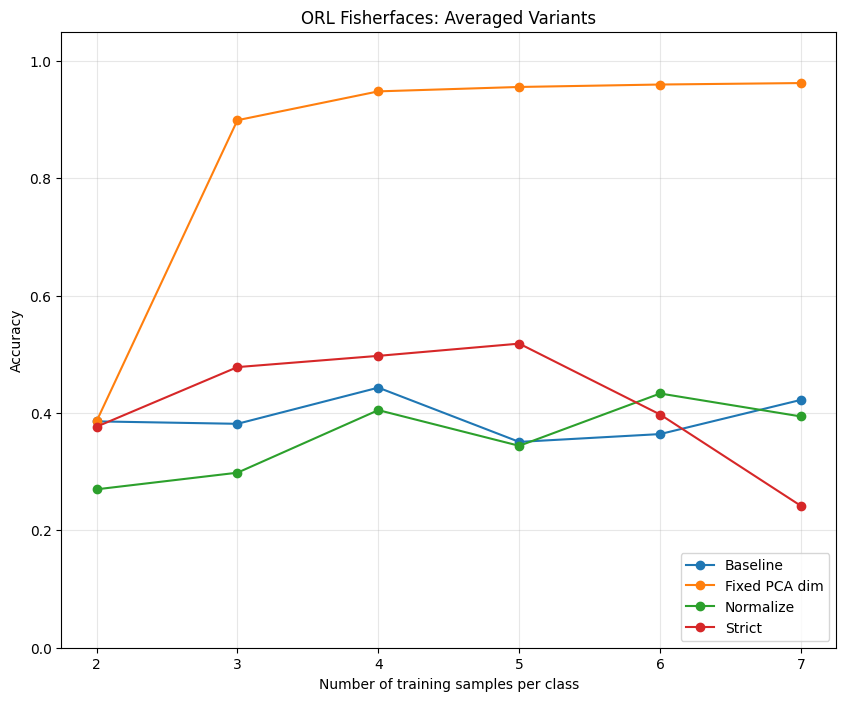

In [59]:
fig = plt.figure(figsize=(10, 8))

plt.plot(sorted_sizes, means, marker="o", label="Baseline")
plt.plot(
    sorted_sizes,
    [mean_scores_fixed[k] for k in sorted_sizes],
    marker="o",
    label="Fixed PCA dim",
)
plt.plot(
    sorted_sizes,
    [mean_scores_norm[k] for k in sorted_sizes],
    marker="o",
    label="Normalize",
)
plt.plot(
    sorted_sizes,
    [mean_scores_strict[k] for k in sorted_sizes],
    marker="o",
    label="Strict",
)

plt.title("ORL Fisherfaces: Averaged Variants")
plt.xlabel("Number of training samples per class")
plt.ylabel("Accuracy")
plt.xticks(sorted_sizes)
plt.grid(True, alpha=0.3)
plt.legend(loc="lower right")
plt.ylim(0, 1.05)
plt.show()


# ORL Sensitivity Checks (Nested Splits)


In [60]:
def make_fisherfaces_fixed_pca():
    return Fisherfaces(**fixed_pca_kwargs)

def make_fisherfaces_normalized():
    return Fisherfaces(**normalized_kwargs)

def make_fisherfaces_strict():
    return Fisherfaces(**strict_kwargs)

pool_perm = make_pool_permutation(data, pool_idx, seed=seed)


In [61]:
acc_nested_base = get_metrics_vs_train_size_nested(
    make_fisherfaces, train_sizes, data, test_idx, pool_perm
)
acc_nested_fixed = get_metrics_vs_train_size_nested(
    make_fisherfaces_fixed_pca, train_sizes, data, test_idx, pool_perm
)
acc_nested_norm = get_metrics_vs_train_size_nested(
    make_fisherfaces_normalized, train_sizes, data, test_idx, pool_perm
)
acc_nested_strict = get_metrics_vs_train_size_nested(
    make_fisherfaces_strict, train_sizes, data, test_idx, pool_perm
)


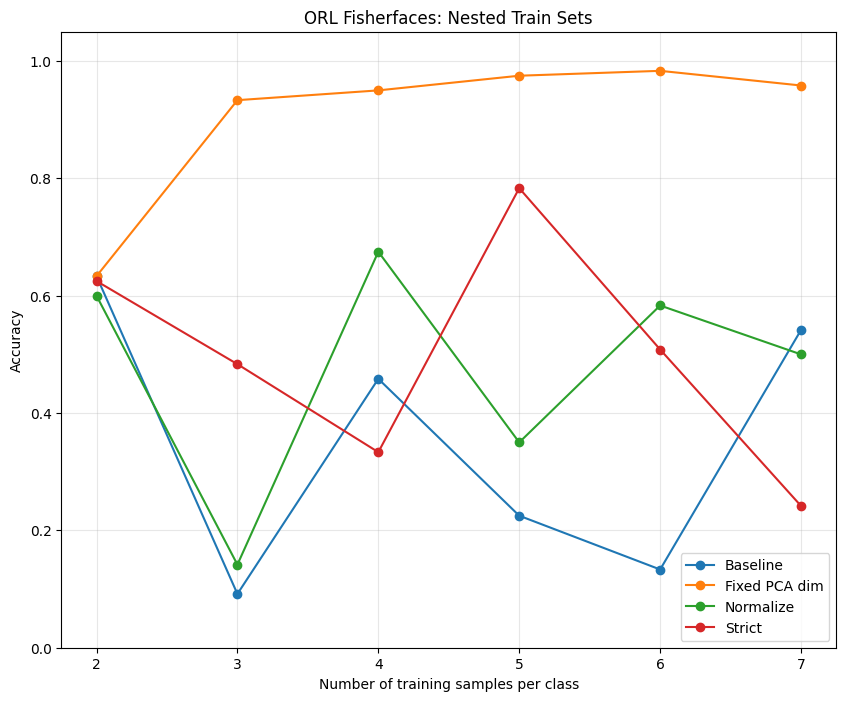

In [62]:
fig = plt.figure(figsize=(10, 8))

plt.plot(train_sizes, [acc_nested_base[t] for t in train_sizes], marker="o", label="Baseline")
plt.plot(train_sizes, [acc_nested_fixed[t] for t in train_sizes], marker="o", label="Fixed PCA dim")
plt.plot(train_sizes, [acc_nested_norm[t] for t in train_sizes], marker="o", label="Normalize")
plt.plot(train_sizes, [acc_nested_strict[t] for t in train_sizes], marker="o", label="Strict")

plt.title("ORL Fisherfaces: Nested Train Sets")
plt.xlabel("Number of training samples per class")
plt.ylabel("Accuracy")
plt.xticks(train_sizes)
plt.grid(True, alpha=0.3)
plt.legend(loc="lower right")
plt.ylim(0, 1.05)
plt.show()


# ORL Robustness (Test-Set Degradations)


In [63]:
angles = [0, 15, 20, 30, 45]
results_rotate = {}
for angle in angles:
    new_data, new_test_idx = transform_test_set(
        data, test_idx, operation="rotate", angle=angle
    )
    accuracy_scores, _ = get_metrics_vs_train_size_joblib(
        make_fisherfaces,
        train_sizes,
        new_data,
        new_test_idx,
        pool_idx,
        seed=seed,
        n_jobs=4,
    )
    results_rotate[angle] = accuracy_scores


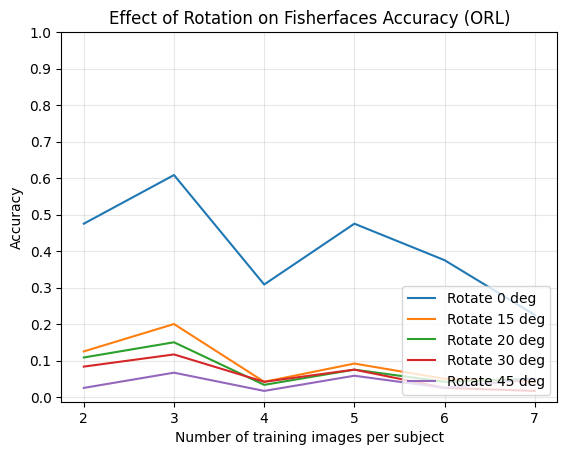

In [64]:
fig = plt.figure()

for angle, scores in results_rotate.items():
    scores = [scores[ts] for ts in train_sizes]
    plt.plot(train_sizes, scores, label=f"Rotate {angle} deg")

plt.xlabel("Number of training images per subject")
plt.ylabel("Accuracy")
plt.title("Effect of Rotation on Fisherfaces Accuracy (ORL)")
plt.grid(True, alpha=0.3)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.legend(loc="lower right")
plt.show()


In [65]:
np.random.seed(seed)
noise_stds = [0, 1, 5, 10, 20]
results_noise = {}
for std in noise_stds:
    new_data, new_test_idx = transform_test_set(
        data, test_idx, operation="noise", noise_std=std
    )
    accuracy_scores, _ = get_metrics_vs_train_size_joblib(
        make_fisherfaces,
        train_sizes,
        new_data,
        new_test_idx,
        pool_idx,
        seed=seed,
        n_jobs=4,
    )
    results_noise[std] = accuracy_scores


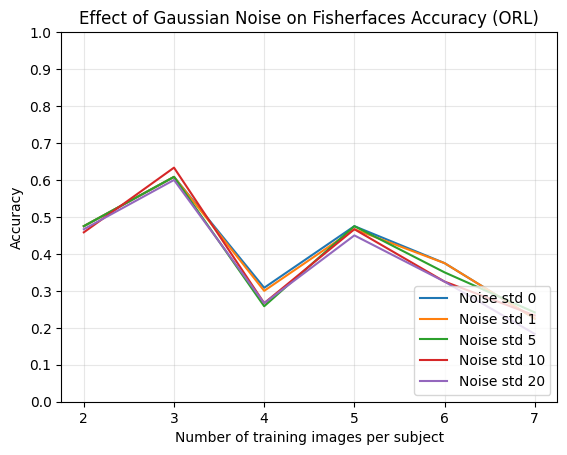

In [66]:
fig = plt.figure()

for std, scores in results_noise.items():
    scores = [scores[ts] for ts in train_sizes]
    plt.plot(train_sizes, scores, label=f"Noise std {std}")

plt.xlabel("Number of training images per subject")
plt.ylabel("Accuracy")
plt.title("Effect of Gaussian Noise on Fisherfaces Accuracy (ORL)")
plt.grid(True, alpha=0.3)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.legend(loc="lower right")
plt.show()


In [67]:
blur_stds = [0, 1, 3, 5, 7]
results_blur = {}
for std in blur_stds:
    new_data, new_test_idx = transform_test_set(
        data, test_idx, operation="blur", blur_std=std
    )
    accuracy_scores, _ = get_metrics_vs_train_size_joblib(
        make_fisherfaces,
        train_sizes,
        new_data,
        new_test_idx,
        pool_idx,
        seed=seed,
        n_jobs=4,
    )
    results_blur[std] = accuracy_scores


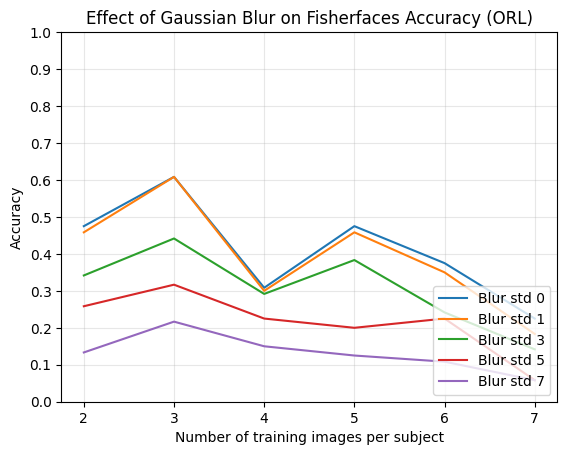

In [68]:
fig = plt.figure()

for std, scores in results_blur.items():
    scores = [scores[ts] for ts in train_sizes]
    plt.plot(train_sizes, scores, label=f"Blur std {std}")

plt.xlabel("Number of training images per subject")
plt.ylabel("Accuracy")
plt.title("Effect of Gaussian Blur on Fisherfaces Accuracy (ORL)")
plt.grid(True, alpha=0.3)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.legend(loc="lower right")
plt.show()


In [69]:
flips = ["", "horizontal", "vertical"]
results_flip = {}
for flip_code in flips:
    new_data, new_test_idx = transform_test_set(
        data, test_idx, operation="flip", flip_direction=flip_code
    )
    accuracy_scores, _ = get_metrics_vs_train_size_joblib(
        make_fisherfaces,
        train_sizes,
        new_data,
        new_test_idx,
        pool_idx,
        seed=seed,
        n_jobs=4,
    )
    results_flip[flip_code] = accuracy_scores


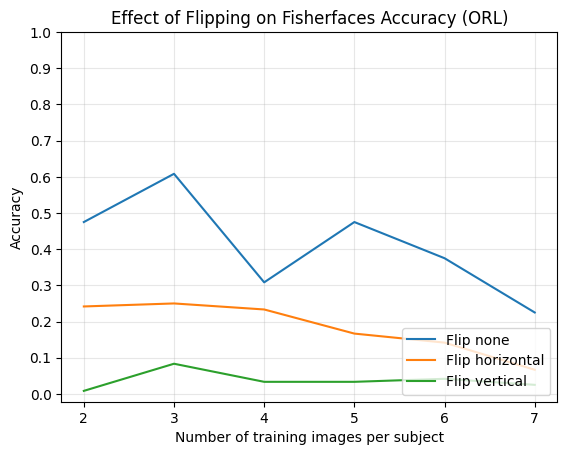

In [70]:
fig = plt.figure()

for flip_code, scores in results_flip.items():
    scores = [scores[ts] for ts in train_sizes]
    label = "none" if flip_code == "" else flip_code
    plt.plot(train_sizes, scores, label=f"Flip {label}")

plt.xlabel("Number of training images per subject")
plt.ylabel("Accuracy")
plt.title("Effect of Flipping on Fisherfaces Accuracy (ORL)")
plt.grid(True, alpha=0.3)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.legend(loc="lower right")
plt.show()


In [71]:
brightness_factors = [0.1, 0.5, 1.0, 2.0, 5.0]
results_brightness = {}
for factor in brightness_factors:
    new_data, new_test_idx = transform_test_set(
        data, test_idx, operation="brightness", brightness_factor=factor
    )
    accuracy_scores, _ = get_metrics_vs_train_size_joblib(
        make_fisherfaces,
        train_sizes,
        new_data,
        new_test_idx,
        pool_idx,
        seed=seed,
        n_jobs=4,
    )
    results_brightness[factor] = accuracy_scores


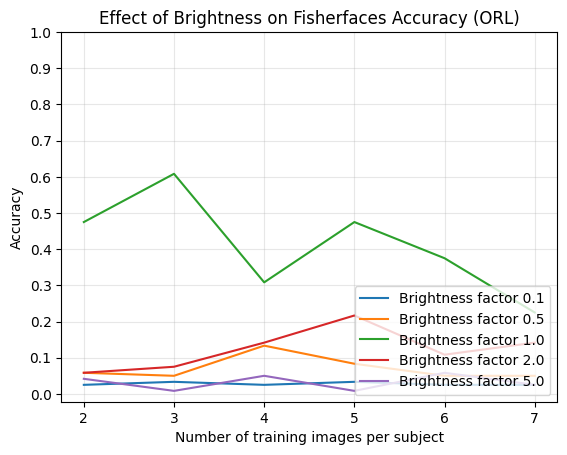

In [72]:
fig = plt.figure()

for factor, scores in results_brightness.items():
    scores = [scores[ts] for ts in train_sizes]
    plt.plot(train_sizes, scores, label=f"Brightness factor {factor}")

plt.xlabel("Number of training images per subject")
plt.ylabel("Accuracy")
plt.title("Effect of Brightness on Fisherfaces Accuracy (ORL)")
plt.grid(True, alpha=0.3)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.legend(loc="lower right")
plt.show()


# Yale Dataset Experiments (Fisherfaces)


In [73]:
data = load_yale("../data/Yale")
max_idx = max(data.keys())
min_length = min(len(images) for images in data.values())
print(
    f"Loaded Yale dataset with {max_idx} subjects with at least {min_length} images each."
)

train_sizes = np.arange(2, min_length - n_test + 1)
test_idx, pool_idx = make_fixed_test_indices(data, n_test=n_test, seed=seed)


Loaded Yale dataset with 15 subjects with at least 11 images each.


In [74]:
model = Fisherfaces(**fisherfaces_kwargs)
print(f"Evaluating Fisherfaces on Yale dataset with train sizes: {train_sizes}")
accuracy_scores, conf_matrices = get_metrics_vs_train_size(
    model, train_sizes, data, test_idx, pool_idx, seed=seed
)


Evaluating Fisherfaces on Yale dataset with train sizes: [2 3 4 5 6 7 8]


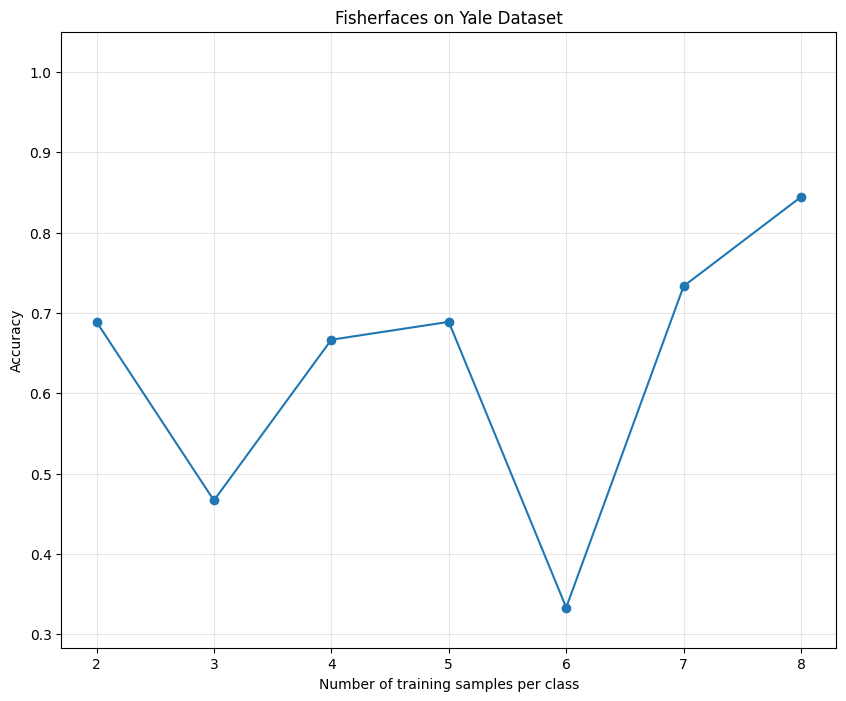

In [75]:
fig = plt.figure(figsize=(10, 8))
plt.plot(train_sizes, accuracy_scores.values(), marker="o")
plt.title("Fisherfaces on Yale Dataset")
plt.xlabel("Number of training samples per class")
plt.ylabel("Accuracy")
plt.xticks(train_sizes)
plt.grid(True, alpha=0.3)
plt.ylim(min(accuracy_scores.values()) - 0.05, 1.05)
plt.show()


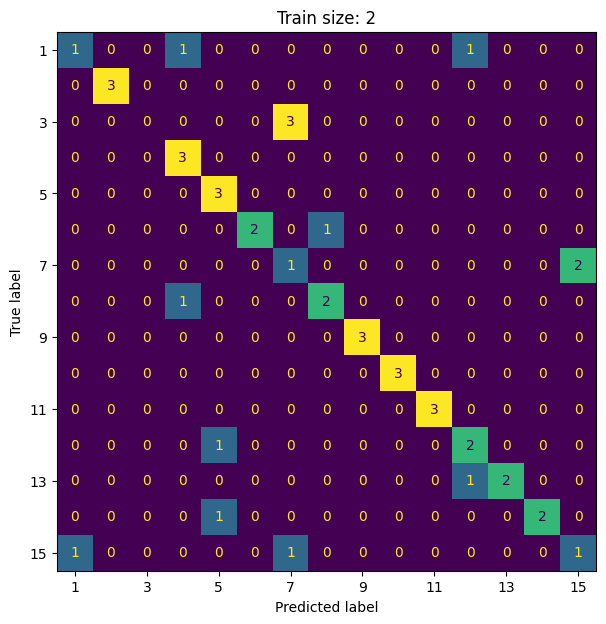

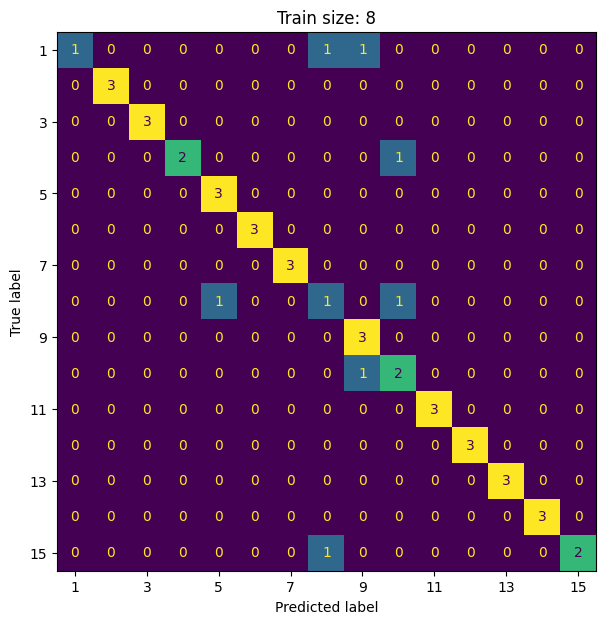

In [76]:
sizes_to_plot = [train_sizes[0], train_sizes[-1]]

for size in sizes_to_plot:
    cm = conf_matrices[size]

    fig, ax = plt.subplots(figsize=(7, 7))

    labels = np.arange(1, cm.shape[0] + 1)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(colorbar=False, ax=ax)

    tick_positions = np.arange(0, cm.shape[0], 2)
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(labels[tick_positions])
    ax.set_yticks(tick_positions)
    ax.set_yticklabels(labels[tick_positions])

    plt.title(f"Train size: {size}")
    plt.show()


Experiments: 100%|██████████| 10/10 [00:54<00:00,  5.46s/it]


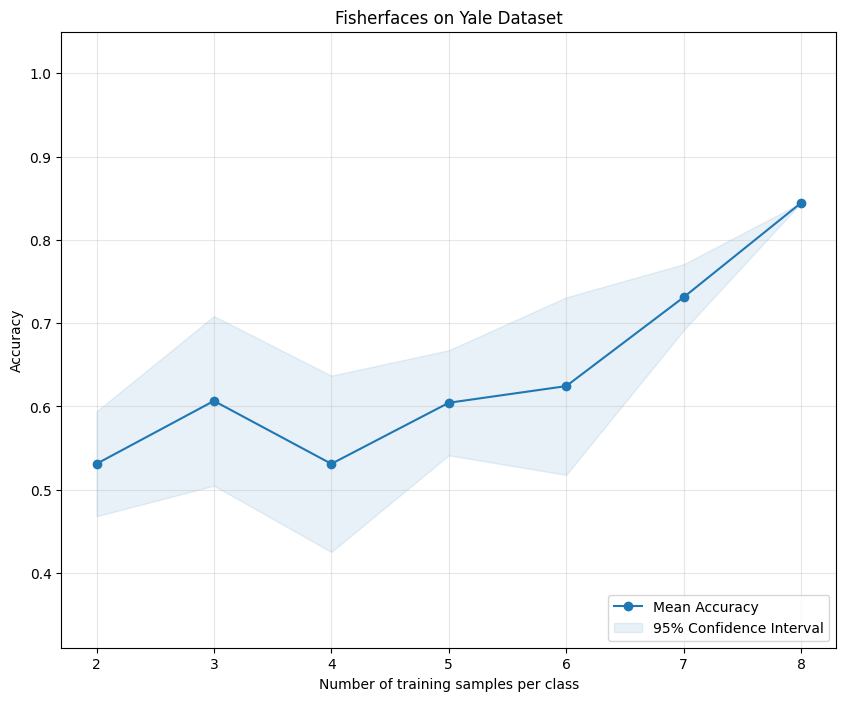

In [77]:
mean_scores, std_scores = get_average_acc_vs_train_size(
    model, train_sizes, data, test_idx, pool_idx, n_exp=n_exp, seed_master=seed
)

sorted_sizes = sorted(mean_scores.keys())
means = np.array([mean_scores[k] for k in sorted_sizes])
stds = np.array([std_scores[k] for k in sorted_sizes])
ci = 1.96 * stds / np.sqrt(n_exp)

fig = plt.figure(figsize=(10, 8))

plt.plot(sorted_sizes, means, marker="o", color="tab:blue", label="Mean Accuracy")

plt.fill_between(
    sorted_sizes,
    means - ci,
    means + ci,
    alpha=0.1,
    color="tab:blue",
    label="95% Confidence Interval",
)

plt.title("Fisherfaces on Yale Dataset")
plt.xlabel("Number of training samples per class")
plt.ylabel("Accuracy")

plt.xticks(sorted_sizes)

plt.grid(True, alpha=0.3)
plt.legend(loc="lower right")

y_min = max(0, min(means - stds) - 0.05)
plt.ylim(y_min, 1.05)

plt.show()


# Yale Variant Comparison (Averaged)


In [78]:
n_classes = len(data)
n_features = data[next(iter(data))][0].size
min_train_size = int(train_sizes[0])
k_pca_fixed = min(n_classes * (min_train_size - 1), n_features)
k_lda_fixed = min(n_classes - 1, k_pca_fixed)

fixed_pca_kwargs = {
    **fisherfaces_kwargs,
    "n_components_pca": k_pca_fixed,
    "n_components_lda": k_lda_fixed,
}
normalized_kwargs = {**fisherfaces_kwargs, "normalize": True}
strict_kwargs = {**fisherfaces_kwargs, "strict": True}

model_fixed = Fisherfaces(**fixed_pca_kwargs)
model_norm = Fisherfaces(**normalized_kwargs)
model_strict = Fisherfaces(**strict_kwargs)

mean_scores_fixed, _ = get_average_acc_vs_train_size(
    model_fixed, train_sizes, data, test_idx, pool_idx, n_exp=n_exp, seed_master=seed
)
mean_scores_norm, _ = get_average_acc_vs_train_size(
    model_norm, train_sizes, data, test_idx, pool_idx, n_exp=n_exp, seed_master=seed
)
mean_scores_strict, _ = get_average_acc_vs_train_size(
    model_strict, train_sizes, data, test_idx, pool_idx, n_exp=n_exp, seed_master=seed
)


Experiments: 100%|██████████| 10/10 [01:24<00:00,  8.42s/it]


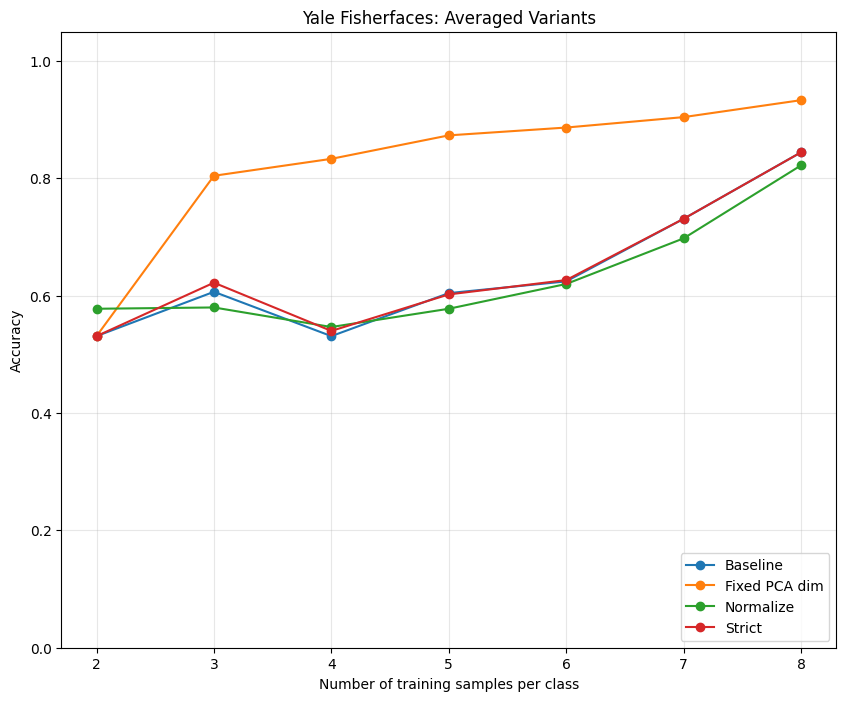

In [79]:
fig = plt.figure(figsize=(10, 8))

plt.plot(sorted_sizes, means, marker="o", label="Baseline")
plt.plot(
    sorted_sizes,
    [mean_scores_fixed[k] for k in sorted_sizes],
    marker="o",
    label="Fixed PCA dim",
)
plt.plot(
    sorted_sizes,
    [mean_scores_norm[k] for k in sorted_sizes],
    marker="o",
    label="Normalize",
)
plt.plot(
    sorted_sizes,
    [mean_scores_strict[k] for k in sorted_sizes],
    marker="o",
    label="Strict",
)

plt.title("Yale Fisherfaces: Averaged Variants")
plt.xlabel("Number of training samples per class")
plt.ylabel("Accuracy")
plt.xticks(sorted_sizes)
plt.grid(True, alpha=0.3)
plt.legend(loc="lower right")
plt.ylim(0, 1.05)
plt.show()


# Yale Sensitivity Checks (Nested Splits)


In [80]:
def make_fisherfaces_fixed_pca():
    return Fisherfaces(**fixed_pca_kwargs)

def make_fisherfaces_normalized():
    return Fisherfaces(**normalized_kwargs)

def make_fisherfaces_strict():
    return Fisherfaces(**strict_kwargs)

pool_perm = make_pool_permutation(data, pool_idx, seed=seed)


In [81]:
acc_nested_base = get_metrics_vs_train_size_nested(
    make_fisherfaces, train_sizes, data, test_idx, pool_perm
)
acc_nested_fixed = get_metrics_vs_train_size_nested(
    make_fisherfaces_fixed_pca, train_sizes, data, test_idx, pool_perm
)
acc_nested_norm = get_metrics_vs_train_size_nested(
    make_fisherfaces_normalized, train_sizes, data, test_idx, pool_perm
)
acc_nested_strict = get_metrics_vs_train_size_nested(
    make_fisherfaces_strict, train_sizes, data, test_idx, pool_perm
)


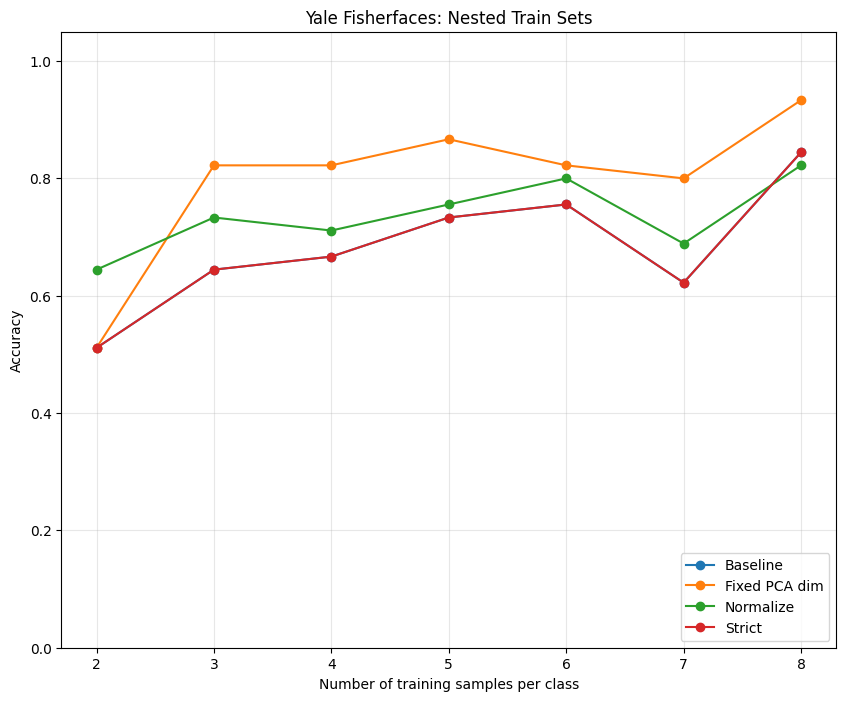

In [82]:
fig = plt.figure(figsize=(10, 8))

plt.plot(train_sizes, [acc_nested_base[t] for t in train_sizes], marker="o", label="Baseline")
plt.plot(train_sizes, [acc_nested_fixed[t] for t in train_sizes], marker="o", label="Fixed PCA dim")
plt.plot(train_sizes, [acc_nested_norm[t] for t in train_sizes], marker="o", label="Normalize")
plt.plot(train_sizes, [acc_nested_strict[t] for t in train_sizes], marker="o", label="Strict")

plt.title("Yale Fisherfaces: Nested Train Sets")
plt.xlabel("Number of training samples per class")
plt.ylabel("Accuracy")
plt.xticks(train_sizes)
plt.grid(True, alpha=0.3)
plt.legend(loc="lower right")
plt.ylim(0, 1.05)
plt.show()
